## Change point detection in energy consumption using Bayesian inference

### Problem definition 
> In the context of building energy management, change point detection plays a very important role in modelling energy usage behaviour of monitored divices, and it is also a critical step in terms of developing the predictive maintenance functionality for Eniscope. We are curious to know if the energy usage patterns from a Eniscope monitored device have changed over time, either gradually or suddenly. Knowing the change points can inform (or alert) the users (clients) that something went wrong (or out of normal) in the circuit, e.g., Did the device break down or is it going to be failed anytime soon? or is it just a planned system shutdown? How can we build a model to automatically detect the change points? 

### Dataset
> To test our change point detection approach for Eniscope dataset, we have chosen Eniscope data recorded from the KFC store in Bracknell. To be more specific, the data we used here was from a Eniscope meter channel that was connected to a air conditioning unit in the store. In addition, we have chosen the period of time during which we know there already exist significant reductions of energy consumption due to the deployment of *ACE2* (BEST energy conservation measures for air conditioning units). Therefore, there should exist a change point to be detected.


In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import glob 
import pickle 
import os

# global settings for figures
fig_params = {'legend.fontsize': 'large',
            #   'figure.figsize': (15, 5),
            'savefig.dpi':300,
            'axes.labelsize': 'x-large',
            'axes.titlesize':'xx-large',
            'xtick.labelsize':'large',
            'ytick.labelsize':'large'}
plt.rcParams.update(fig_params)

In [2]:
fname = 'data-stargazypie-20191001-20200430-17227.pkl'  # sample data from KFC in Bracknell
[data_h, reg_data_h, reg_data_d] = pickle.load(open(os.path.join('data', fname), "rb"))

# Select data from a specific channel - 'Air Con Rest (dcid: 59672)'
# d1 = '20191028'
# d2 = '20191110'
d1 = '20191101'
d2 = '20191106'
# col_sel = 'E_59672'  # air cond rest
# store_name = 'KFC Bracknell'
# dv_name = 'air-con'

col_sel = 'E_59668'  # main incomer
store_name = 'KFC Bracknell'
dv_name = 'main incomer'

##################################################################

# fname = 'data-stargazypie-20191001-20200430-17268.pkl'  # KFC Argyle Road Glasgow
# [data_h, reg_data_h, reg_data_d] = pickle.load(open(os.path.join('data', fname), "rb"))

# # Select data from a specific channel - 'Air Con Rest (dcid: 59672)'

# d1 = '20191104'
# d2 = '20191109'

# # col_sel = 'E_60301'  # main incomer
# # store_name = 'KFC Argyle Rd Glasgow'
# # dv_name = 'main incomer'

# # col_sel = 'E_59967'  # main incomer
# col_sel = 'E_59968'  # extract fan
# store_name = 'KFC Brighton'
# # dv_name = 'main incomer'
# dv_name = 'extract fan'
###################################################################

data_sel = data_h[['datetime', col_sel]].set_index('datetime')[d1:d2]

# Create a new column for rounded data in order to fit Poisson distribution
data_sel[f'{col_sel}_new'] = data_sel[col_sel].apply(lambda x: 0 if x < 0 else x)  # force negative vals to zeros
data_sel[f'{col_sel}_new'] = data_sel[f'{col_sel}_new'].round()  # round energy vals to integer

# Filter out non-working hours
to_remove = [1,2,3,4,5,6,7,8]  # hours to be filtered
working_hours = [h for h in np.arange(24) if h not in to_remove]
data_sel_working = data_sel[data_sel.index.hour.isin(working_hours)]
print(data_sel_working.info())
data_sel_working.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2019-11-01 00:00:00 to 2019-11-06 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   E_59668      96 non-null     float64
 1   E_59668_new  96 non-null     float64
dtypes: float64(2)
memory usage: 2.2 KB
None


,E_59668,E_59668_new
datetime,,
2019-11-01 00:00:00,13145.826147,13146.0
2019-11-01 09:00:00,63476.833346,63477.0
2019-11-01 10:00:00,46738.520077,46739.0
2019-11-01 11:00:00,13361.126331,13361.0
2019-11-01 12:00:00,88526.855940,88527.0


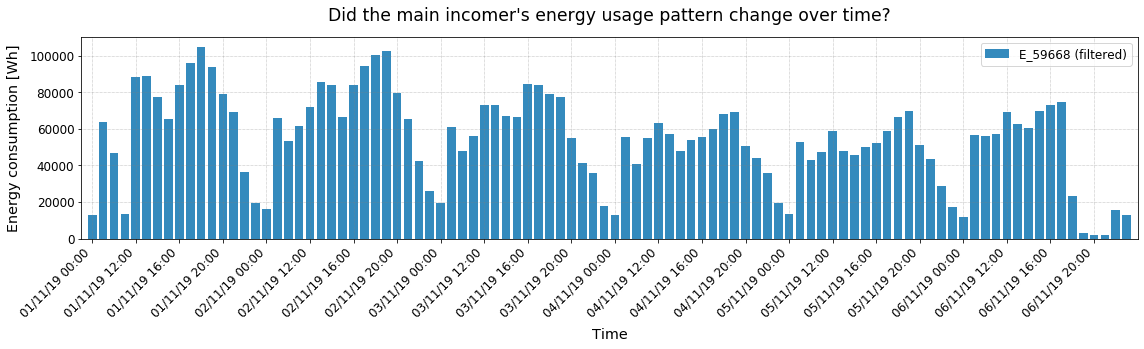

In [3]:
count_data = data_sel_working[f'{col_sel}_new'].values
n_count_data = len(count_data)

# sns.set(font_scale=1.2)
# sns.set_style("whitegrid", {'grid.linestyle': ':'})
fig, ax = plt.subplots(figsize=(16, 5))

# ax.bar(np.arange(n_count_data), count_data, color="#348ABD", label='Energy')
ax.bar(data_sel_working.index.strftime('%d/%m/%y %H:%M').tolist(), count_data, color="#348ABD", label=f'{col_sel} (filtered)')
ax.set_title(f"Did the {dv_name}'s energy usage pattern change over time?", y=1.05)
ax.set_xlabel("Time", labelpad=8)
ax.set_ylabel("Energy consumption [Wh]", labelpad=8)
ax.set_xlim(-1, n_count_data)
ax.grid(which='major', linestyle=':', linewidth='0.5', color='gray')
ax.legend(loc="upper right")

# set sparse xticks
dt_ticks = data_sel_working.index.strftime('%d/%m/%y %H:%M').tolist()[::4]
# dt_ticklabels = [i.strftime('%d/%m') for i in dt_ticks]
ax.set_xticks(dt_ticks) # set sparse xticks
# ax.set_xticklabels(dt_ticklabels)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')  # rotate x ticks

plt.tight_layout()
plt.savefig(f'./plots/observed-eniscope-data-{col_sel}.svg', bbox_inches='tight')
plt.show()

## Modelling

In [4]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean() 
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's *stochastic variables*, so-called because they are treated by the back end as random number generators.

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword. 

The code below will be explained in Chapter 3, but I show it here so you can see where our results come from. One can think of it as a *learning* step. The machinery being employed is called *Markov Chain Monte Carlo* (MCMC), which I also delay explaining until Chapter 3. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called *traces* in the MCMC literature) into histograms.

In [5]:
# MCMC sampling
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

# samples from posterior distributions
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:06<00:00, 9439.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [6]:

# # save posterior distributions
# fname = f'posterior-dists-{col_sel}.pkl'
# posterior_pkl = os.path.join('data', fname)
# with open(posterior_pkl, 'wb') as f:
#     pickle.dump([data_sel_working, lambda_1_samples, lambda_2_samples, tau_samples], f)

## Plot posterior distributions

In [7]:
# Uncomment to load the saved pickle data (without rerunning the simulation)

# col_sel = 'E_59672'
# fname = f'posterior-dists-{col_sel}.pkl'
# [data_sel_working, lambda_1_samples, lambda_2_samples, tau_samples] = pickle.load(open(os.path.join('data', fname), "rb"))
# count_data = data_sel_working[f'{col_sel}_new'].values
# print(count_data.shape)
# n_count_data = len(count_data)

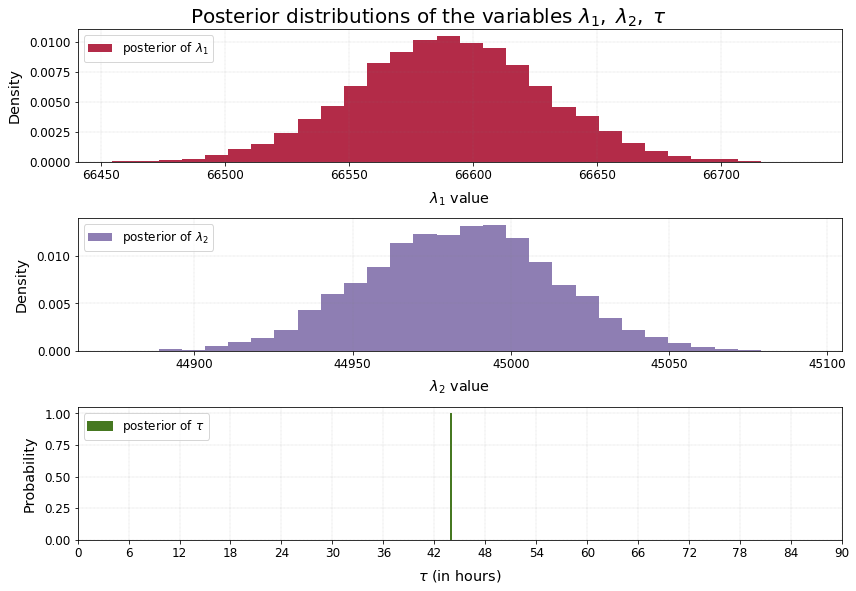

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

ax[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
            label="posterior of $\lambda_1$", color="#A60628", density=True)
ax[0].legend(loc="upper left")
# ax[0].set_title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
# ax[0].set_xlim(320,2500)
ax[0].set_xlabel("$\lambda_1$ value", labelpad=8)
ax[0].set_ylabel("Density", labelpad=8);
ax[0].grid(which='major', linestyle=':', linewidth='0.3', color='gray')

#
ax[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
            label="posterior of $\lambda_2$", color="#7A68A6", density=True)
ax[1].legend(loc="upper left")
ax[1].set_xlabel("$\lambda_2$ value", labelpad=8)
ax[1].set_ylabel("Density", labelpad=8);
ax[1].grid(which='major', linestyle=':', linewidth='0.3', color='gray')

#
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)  # weights
ax[2].hist(tau_samples, bins=n_count_data, alpha=1,
            label=r"posterior of $\tau$",
            color="#467821", edgecolor= "#467821", weights=w, linewidth='2', rwidth=0)
ax[2].set_xlabel(r"$\tau$ (in hours)", labelpad=8)
ax[2].set_ylabel("Probability", labelpad=8)
ax[2].set_xlim([25, len(count_data)-35])
ax[2].legend(loc="upper left")
ax[2].set_xticks(np.arange(n_count_data)[::6])
ax[2].grid(which='major', linestyle=':', linewidth='0.3', color='gray')

#
fig.suptitle(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig(f'./plots/changepoint-posterior-{col_sel}.svg', bbox_inches='tight')
plt.show()


Time of change: 44



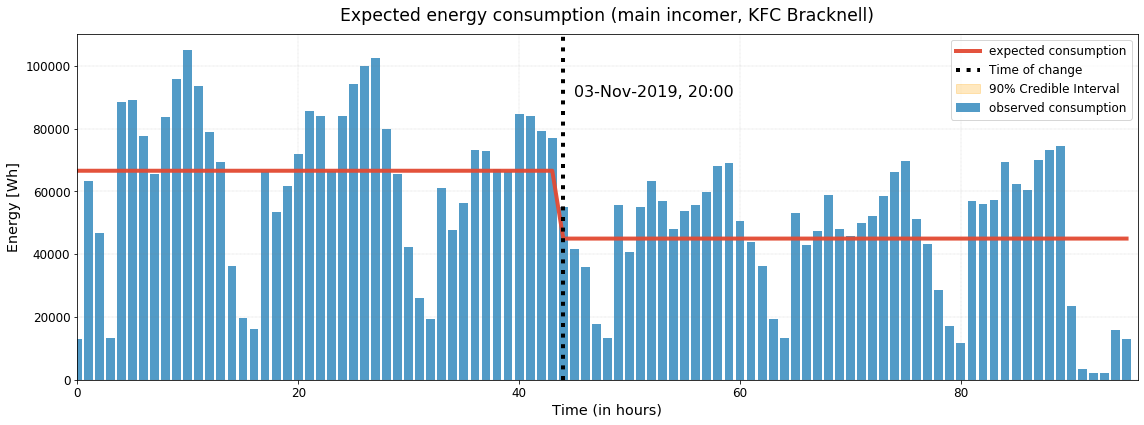

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]

expected_texts_per_day = np.zeros(n_count_data)
perc_rng = np.zeros((n_count_data,2))  # credible interval
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

    v = np.concatenate([lambda_1_samples[ix], lambda_2_samples[~ix]])
    p = 5
    perc_rng[day,:] = np.percentile(v, [p, 100-p])  # 90% CI 

ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
        alpha = 0.95, label="expected consumption")
ax.set_xlim(0, n_count_data)
ax.set_xlabel("Time (in hours)")
ax.set_ylabel("Energy [Wh]")
ax.set_title(f"Expected energy consumption ({dv_name}, {store_name})", y=1.02)
# plt.ylim(0, 60)

# 
ax.fill_between(range(n_count_data), 
                perc_rng[:,0], 
                perc_rng[:,1], 
                alpha = 0.25,
                label = "90% Credible Interval",
                color = "orange")

ax.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.85,
        label="observed consumption")

hour_idx = int(np.ceil(tau_samples.mean()))
change_time = data_sel_working.index.strftime('%d-%b-%Y, %H:%M').tolist()[hour_idx]
print('\nTime of change: {}\n'.format(hour_idx))
ax.axvline(hour_idx, 
        linestyle = ':', linewidth = 4,
        label = "Time of change", 
        color = "black")

style = dict(size=16, color='black')
# ax.text(43, 3950, change_time, transform=ax.transData, **style)  # air con rest
ax.text(45, 90000, change_time, transform=ax.transData, **style)  # main incomer bracknell
# ax.text(52, 48500, change_time, transform=ax.transData, **style)  # main incomer

# Decoration
ax.grid(which='major', linestyle=':', linewidth='0.3', color='gray')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f'./plots/estimated-changepoint-{col_sel}.svg', bbox_inches='tight')
plt.show()